In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install simpletransformers
!pip install scikit-learn
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn

In [2]:
# defining code to load datasets
data_root = "data/raw_data/"
pcl_path = data_root + "dontpatronizeme_pcl.tsv"
categories_path = data_root + "dontpatronizeme_categories.tsv"
train_split_path = data_root + "train_semeval_parids-labels.csv"
val_split_path = data_root + "dev_semeval_parids-labels.csv"
# only load this for generating test results at the end!
test_path = data_root + "task4_test.tsv"

def load_pcl(pcl):
    columns = ['par_id', 'art_id', 'keyword', 'country_code', 'text', 'label_original']
    df = pd.read_csv(pcl, sep='\t', skiprows=4, names=columns)
    # get binary pcl label based on original label
    df['label'] = (df['label_original'] > 1).astype(int)
    return df

def load_categories(categories):
    columns = ['par_id', 'art_id', 'text', 'keyword', 'country_code', 'span_start', 'span_finish', 'span_text', 'pcl_category', 'number_of_annotators']
    df = pd.read_csv(categories, sep='\t', skiprows=4, names=columns)
    return df

def load_train_val_idx(train_path, val_path):
    train_df = pd.read_csv(train_path, sep=",", header=0)
    val_df = pd.read_csv(val_path, sep=",", header=0)
    train_idx = train_df['par_id'].values
    val_idx = val_df['par_id'].values
    return train_idx, val_idx

def load_test_data(test_path):
    # test data has no label
    columns = ['par_id', 'art_id', 'keyword', 'country_code', 'text']
    # also, test data has no disclaimer at beginning
    df = pd.read_csv(test_path, sep='\t', names=columns)
    return df

In [79]:
pcl_df = load_pcl(pcl_path)
pcl_df

,par_id,art_id,keyword,country_code,text,label_original,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1
10467,10468,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4,1


In [34]:
value_counts = pcl_df['keyword'].value_counts()
print(value_counts)

keyword
migrant          1089
in-need          1082
vulnerable       1080
homeless         1077
women            1070
refugee          1068
immigrant        1061
disabled         1028
hopeless         1005
poor-families     909
Name: count, dtype: int64


In [5]:
pcl_df.isna().sum()

par_id            0
art_id            0
keyword           0
country_code      0
text              1
label_original    0
label             0
dtype: int64

In [6]:
pcl_df[pcl_df['text'].isna()]

,par_id,art_id,keyword,country_code,text,label_original,label
8639,8640,@@16852855,migrant,ke,NaN,0,0


In [80]:
# Replacing the missing text with ""
pcl_df['text'] = pcl_df['text'].fillna('')

In [8]:
pcl_df.isna().sum()

par_id            0
art_id            0
keyword           0
country_code      0
text              0
label_original    0
label             0
dtype: int64

In [82]:
pcl_df['text_length'] = pcl_df['text'].apply(lambda x: len(x))

In [83]:
pcl_df.head()

,par_id,art_id,keyword,country_code,text,label_original,label,text_length
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,620
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,237
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0,158
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,162
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0,273


## Part 1 Data Analysis

In [43]:
grouped = pcl_df.groupby('label')

# Count the number of rows with each label
count_per_label = grouped.size()
percentages = (count_per_label / len(pcl_df)) * 100

print("Counts and percentages per label:")
for label in count_per_label.index:
    print(f"Label {label}: Count = {count_per_label[label]}, Percentage = {percentages[label]:.2f}%")

Counts and percentages per label:
Label 0: Count = 9476, Percentage = 90.51%
Label 1: Count = 993, Percentage = 9.49%


In [44]:
# Calculate the average value of 'text_length' for each label
mean_text_length_per_label = grouped['text_length'].mean()
print("\nMean text length per label:")
for label in mean_text_length_per_label.index:
    print(f"Label {label}: Mean text length = {mean_text_length_per_label[label]:.2f}")


Mean text length per label:
Label 0: Mean text length = 264.36
Label 1: Mean text length = 287.06


In [45]:
grouped = pcl_df.groupby('label_original')

# Count the number of rows with each label
count_per_label = grouped.size()
percentages = (count_per_label / len(pcl_df)) * 100

print("Counts and percentages per label:")
for label in count_per_label.index:
    print(f"Label {label}: Count = {count_per_label[label]}, Percentage = {percentages[label]:.2f}%")

Counts and percentages per label:
Label 0: Count = 8529, Percentage = 81.47%
Label 1: Count = 947, Percentage = 9.05%
Label 2: Count = 144, Percentage = 1.38%
Label 3: Count = 458, Percentage = 4.37%
Label 4: Count = 391, Percentage = 3.73%


In [46]:
# Calculate the average value of 'text_length' for each label
mean_text_length_per_label = grouped['text_length'].mean()
print("\nMean text length per label:")
for label in mean_text_length_per_label.index:
    print(f"Label {label}: Mean text length = {mean_text_length_per_label[label]:.2f}")


Mean text length per label:
Label 0: Mean text length = 262.31
Label 1: Mean text length = 282.82
Label 2: Mean text length = 269.27
Label 3: Mean text length = 277.38
Label 4: Mean text length = 304.95


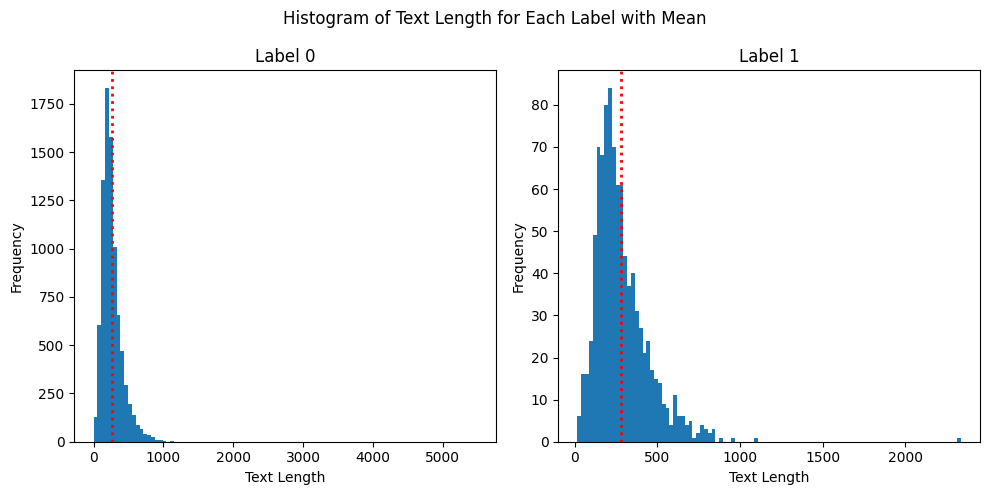

In [47]:
# Create subplots for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms of 'text_length' for each label
for ax, (label, group) in zip(axs, grouped):
    ax.hist(group['text_length'], bins=100)
    ax.axvline(group['text_length'].mean(), color='red', linestyle='dotted', linewidth=2)
    ax.set_title(f'Label {label}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

plt.suptitle('Histogram of Text Length for Each Label with Mean')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

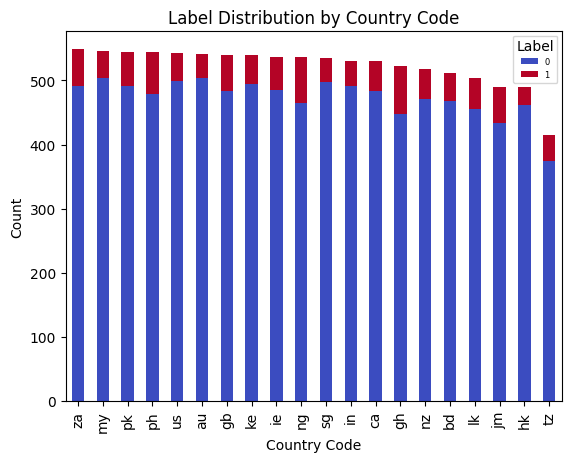

In [48]:
# Count of each label for each country code
label_counts = pd.crosstab(pcl_df['country_code'], pcl_df['label'])

# Sort bars by total count for each country code
total_counts = label_counts.sum(axis=1).sort_values(ascending=False).index
label_counts = label_counts.loc[total_counts]

# Plot stacked bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Label Distribution by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Count')
plt.legend(title='Label', loc='upper right', fontsize='6')
plt.show()

   country_code      label
4            gh  14.340344
12           ng  13.407821
14           ph  12.293578
8            jm  11.632653
19           za  10.564663
3            gb  10.555556
17           tz   9.879518
15           pk   9.724771
10           lk   9.722222
6            ie   9.683426
13           nz   9.073359
2            ca   8.679245
1            bd   8.593750
9            ke   8.348794
18           us   8.103131
11           my   7.875458
7            in   7.358491
16           sg   7.102804
0            au   6.839187
5            hk   5.918367


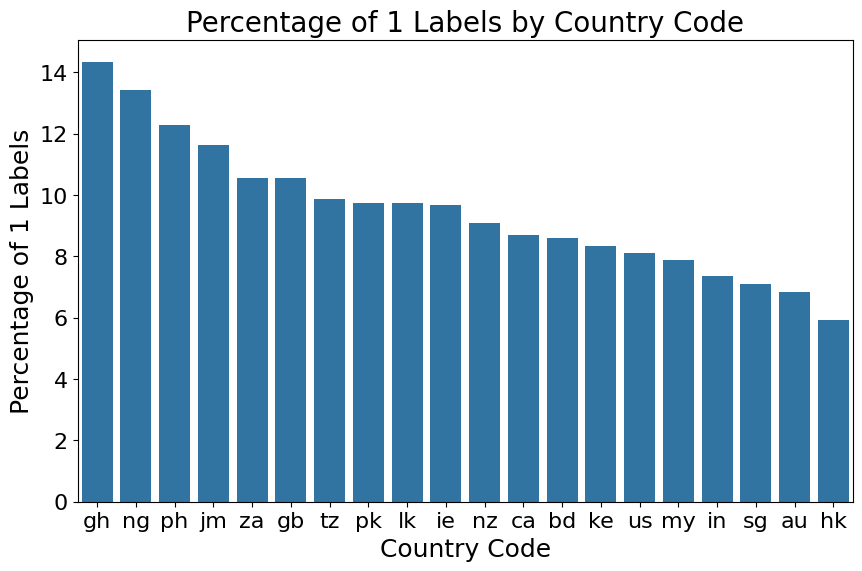

In [122]:
# Calculate the percentage of 1 labels for each country code
label_percentage = pcl_df.groupby('country_code')['label'].mean() * 100
label_percentage = label_percentage.reset_index().sort_values(by='label', ascending=False)

print(label_percentage)

# Plot percentage of 1 labels for each country code
plt.figure(figsize=(10, 6))
sns.barplot(data=label_percentage, x='country_code', y='label')
plt.title('Percentage of 1 Labels by Country Code', fontsize=20)
plt.xlabel('Country Code', fontsize=18)
plt.ylabel('Percentage of 1 Labels', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

<Figure size 1000x600 with 0 Axes>

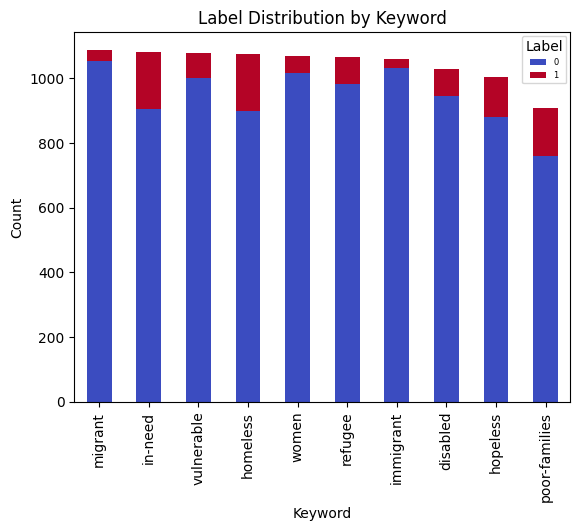

In [50]:
# Count of each label for each country code
label_counts = pd.crosstab(pcl_df['keyword'], pcl_df['label'])

# Sort bars by total count for each country code
total_counts = label_counts.sum(axis=1).sort_values(ascending=False).index
label_counts = label_counts.loc[total_counts]

# Plot stacked bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Label Distribution by Keyword')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.legend(title='Label', loc='upper right', fontsize='6')
plt.show()

         keyword      label
1       homeless  16.527391
6  poor-families  16.501650
4        in-need  16.266174
2       hopeless  12.338308
7        refugee   8.052434
0       disabled   7.879377
8     vulnerable   7.407407
9          women   4.859813
5        migrant   3.305785
3      immigrant   2.827521


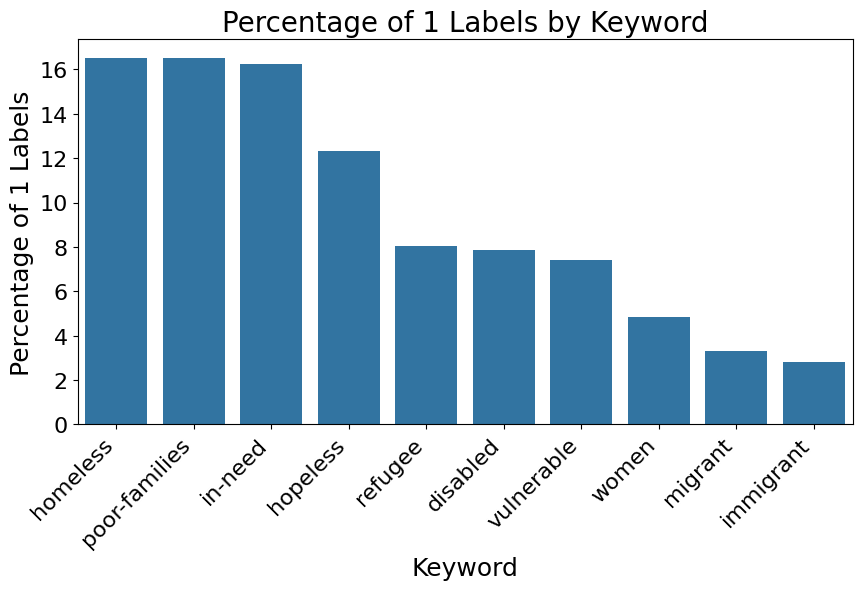

In [123]:
# Calculate the percentage of 1 labels for each keyword
label_percentage = pcl_df.groupby('keyword')['label'].mean() * 100
label_percentage = label_percentage.reset_index().sort_values(by='label', ascending=False)
print(label_percentage)

# Plot percentage of 1 labels for each country code
plt.figure(figsize=(10, 5))
sns.barplot(data=label_percentage, x='keyword', y='label')
plt.title('Percentage of 1 Labels by Keyword', fontsize=20)
plt.xlabel('Keyword', fontsize=18)
plt.ylabel('Percentage of 1 Labels', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)

plt.show()

### Preprocessing

In [94]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

# Function to preprocess text
def preprocess_text(text, lowercase=False, remove_punctuation=False, remove_stopwords=False, stemming=False, lemmatization=False):
    assert(not (stemming and lemmatization))
    # Lowercasing
    if lowercase:
        text = text.lower()
    # Removing punctuation
    if remove_punctuation:
        text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    if stemming:
        porter = PorterStemmer()
        tokens = [porter.stem(word) for word in tokens]
    # Lemmatization
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Joining tokens back into text
    processed_text = ' '.join(tokens)
    return processed_text

# Apply preprocessing function to text column
pcl_df['preprocessed_text'] = pcl_df['text'].apply(preprocess_text, lowercase=True, remove_punctuation=True, remove_stopwords=True, lemmatization=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jonezia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jonezia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jonezia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
print(pcl_df.iloc[0]['text'])
print()
print(pcl_df.iloc[0]['preprocessed_text'])

We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism .

living time absolute insanity pretty sure people aware waking every day check news seemed carry feeling panic dread action hero probably face trying decide whether cut blue green wire ticking bomb except bomb instruction long ago burned fire imminent catastrophe seems likeliest outcome hard stay onedge long though natural people become inured constant chaos slump malaise hope

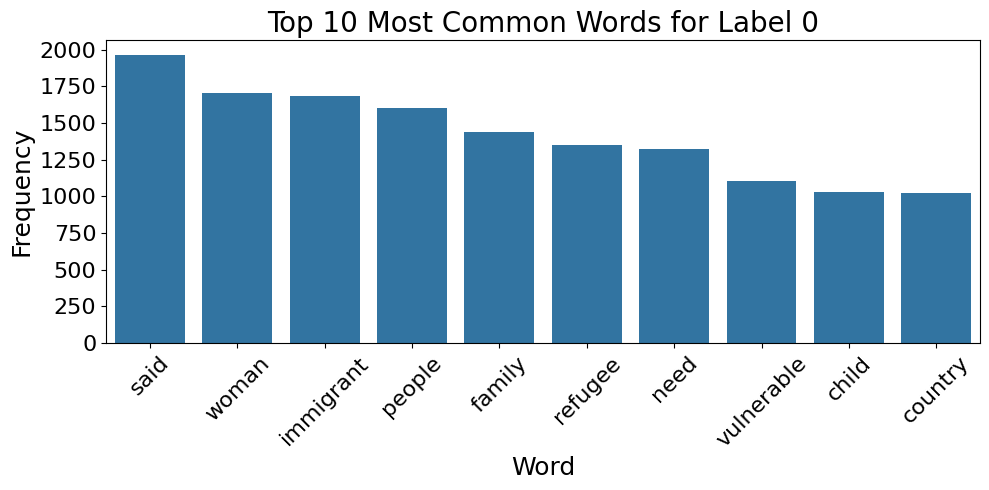

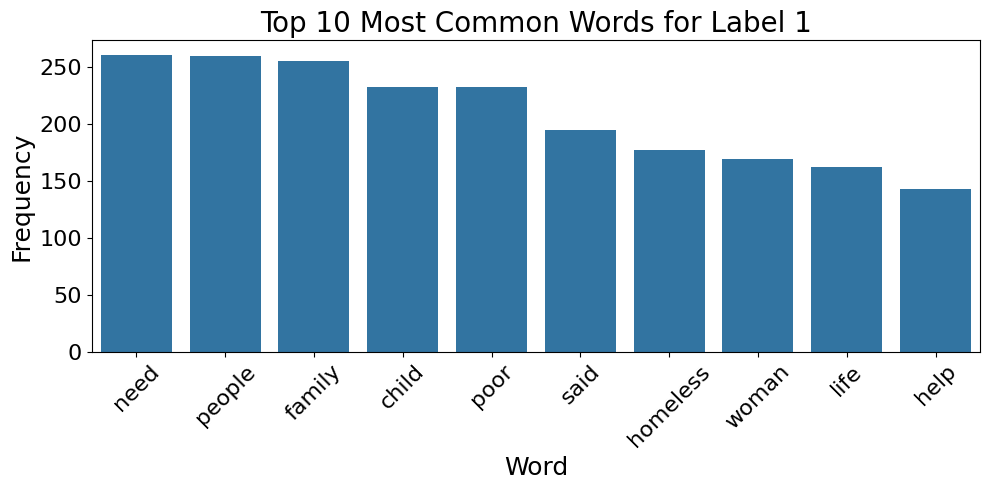

In [104]:
from collections import Counter

# Separate preprocessed text associated with label 0 and label 1
text_label_0 = ' '.join(pcl_df[pcl_df['label'] == 0]['preprocessed_text'])
text_label_1 = ' '.join(pcl_df[pcl_df['label'] == 1]['preprocessed_text'])

# Tokenize the text to extract individual words
tokens_label_0 = word_tokenize(text_label_0)
tokens_label_1 = word_tokenize(text_label_1)

# Count the frequency of each word in each bag of words
word_freq_label_0 = Counter(tokens_label_0)
word_freq_label_1 = Counter(tokens_label_1)

# Plot for Label 0
plt.figure(figsize=(10, 5))
sns.barplot(x=[pair[0] for pair in word_freq_label_0.most_common(10)], y=[pair[1] for pair in word_freq_label_0.most_common(10)])
plt.title('Top 10 Most Common Words for Label 0', fontsize=20)
plt.xlabel('Word', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# Plot for Label 1
plt.figure(figsize=(10, 5))
sns.barplot(x=[pair[0] for pair in word_freq_label_1.most_common(10)], y=[pair[1] for pair in word_freq_label_1.most_common(10)])
plt.title('Top 10 Most Common Words for Label 1', fontsize=20)
plt.xlabel('Word', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

## Model
First, we split the data into train/val/test. I use the official validation set as my "test" data, and split the official train set to form the validation and training datasets.

In [7]:
official_train_idx, official_val_idx = load_train_val_idx(train_split_path, val_split_path)
print(official_train_idx.shape)
print(official_val_idx.shape)

(8375,)
(2094,)


In [41]:
from sklearn.model_selection import train_test_split
# Split data into training validation and test data according to official idx

rows = [] # will contain par_id, label and text
for parid in official_train_idx:  
  # select row from original dataset
  keyword = pcl_df.loc[pcl_df.par_id == parid].keyword.values[0]
  text = pcl_df.loc[pcl_df.par_id == parid].text.values[0]
  text_length = pcl_df.loc[pcl_df.par_id == parid].text_length.values[0]
  label_original = pcl_df.loc[pcl_df.par_id == parid].label_original.values[0]
  label = pcl_df.loc[pcl_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'keyword':keyword,
      'original_text':text,
      'text':text,
      'text_length': text_length,
      'label_original': label_original,
      'labels':label
  })
train_data_ = pd.DataFrame(rows)
train_data, val_data = train_test_split(train_data_, test_size=0.2, shuffle=True, random_state=42)

rows = [] # will contain par_id, label and text
for parid in official_val_idx:  
  # select row from original dataset
  keyword = pcl_df.loc[pcl_df.par_id == parid].keyword.values[0]
  text = pcl_df.loc[pcl_df.par_id == parid].text.values[0]
  text_length = pcl_df.loc[pcl_df.par_id == parid].text_length.values[0]
  label_original = pcl_df.loc[pcl_df.par_id == parid].label_original.values[0]
  label = pcl_df.loc[pcl_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'keyword':keyword,
      'original_text':text,
      'text':text,
      'text_length': text_length,
      'label_original': label_original,
      'labels':label
  })
test_data = pd.DataFrame(rows)

print(f"Train data: {len(train_data)}")
print(f"Val data: {len(val_data)}")
print(f"Test data: {len(test_data)}")

Train data: 6700
Val data: 1675
Test data: 2094


In [42]:
train_data.head()

,par_id,keyword,original_text,text,text_length,label_original,labels
5714,5423,disabled,Critics have even taken to dobbing in Katrina ...,Critics have even taken to dobbing in Katrina ...,180,0,0
7023,6890,in-need,Alexis and her family decided to donate more t...,Alexis and her family decided to donate more t...,93,0,0
664,1394,vulnerable,"Mr Porter , do you think you will get the numb...","Mr Porter , do you think you will get the numb...",230,4,1
4810,4445,vulnerable,""" This only serves to highlight the importance...",""" This only serves to highlight the importance...",287,1,0
8019,7991,hopeless,""" I was nervous , but life has taught me over ...",""" I was nervous , but life has taught me over ...",273,0,0


In [43]:
val_data.head()

,par_id,keyword,original_text,text,text_length,label_original,labels
4727,4355,in-need,The Kindness Institute came about through Cavi...,The Kindness Institute came about through Cavi...,122,0,0
8161,8147,refugee,Minister Swaminathan forwarded a Cabinet paper...,Minister Swaminathan forwarded a Cabinet paper...,249,0,0
2333,1728,migrant,Human Rights Watch last month released a repor...,Human Rights Watch last month released a repor...,289,0,0
4204,3781,migrant,"The book is "" Never Look an American in the Ey...","The book is "" Never Look an American in the Ey...",469,0,0
5404,5083,immigrant,Born to immigrant Indian parents in the small ...,Born to immigrant Indian parents in the small ...,272,0,0


In [44]:
test_data.head()

,par_id,keyword,original_text,text,text_length,label_original,labels
0,4046,hopeless,We also know that they can benefit by receivin...,We also know that they can benefit by receivin...,493,3,1
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,Pope Francis washed and kissed the feet of Mus...,197,4,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,Many refugees do n't want to be resettled anyw...,74,2,1
3,4063,in-need,"Budding chefs , like "" Fred "" , "" Winston "" an...","Budding chefs , like "" Fred "" , "" Winston "" an...",210,4,1
4,4089,homeless,"In a 90-degree view of his constituency , one ...","In a 90-degree view of his constituency , one ...",351,3,1


Code to train the model

In [9]:
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import classification_report, precision_recall_fscore_support

cuda_available = torch.cuda.is_available()

def train_model(train_data, val_data, num_epoch=1, model_type="roberta", model_name="roberta-base", learning_rate=4e-5, scheduler="linear_schedule_with_warmup", optimizer="AdamW"):
    model_args = ClassificationArgs(num_train_epochs=num_epoch, 
                                    no_save=True, 
                                    no_cache=True, 
                                    overwrite_output_dir=True,
                                    use_multiprocessing=False,
                                    use_multiprocessing_for_evaluation=False,
                                    train_batch_size=8,
                                    eval_batch_size=8,
                                    learning_rate=learning_rate,
                                    scheduler=scheduler,
                                    optimizer=optimizer)
    model = ClassificationModel(model_type,
                                model_name, 
                                args = model_args, 
                                num_labels=2, 
                                use_cuda=cuda_available)
    # train model
    model.train_model(train_data[['text', 'labels']])

    # test on validation data
    y_pred, _ = model.predict(val_data.text.tolist())
    y_true = val_data['labels']
    print("Validation Set Metrics")
    print(classification_report(y_true, y_pred, digits=4))
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)
    del model
    return f1_score[1]

## Preprocessing Exploration

In [21]:
# Downsampling train data (in the same way as RoBERTa base model)
train_label_1 = train_data[train_data.labels==1]
num_label_1 = len(train_label_1)
train_label_0 = train_data[train_data.labels==0][:num_label_1*2]
train_data_downsampled = pd.concat([train_label_1,train_label_0])
print(f"Train data: {len(train_data_downsampled)}")

Train data: 1881


First, we train the default model without any preprocessing for comparison.

In [ ]:
f1_results_hyperparams = {}

In [28]:
f1_results_hyperparams['default'] = train_model(train_data_downsampled, val_data)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9790    0.8504    0.9102      1537
           1     0.3235    0.7971    0.4603       138

    accuracy                         0.8460      1675
   macro avg     0.6513    0.8237    0.6852      1675
weighted avg     0.9250    0.8460    0.8731      1675

0.9101671309192201
0.4602510460251046


Now, we iterate over each possible preprocessing step and set them individually to true to see if the model performance improves.

In [32]:
preprocessing_hyperparams = {'lowercase': False, 'remove_punctuation': False, 'remove_stopwords': False, 'stemming': False, 'lemmatization': False}
for hyperparam in preprocessing_hyperparams:
    print(f"Training with {hyperparam} preprocessing step")
    preprocessing_hyperparams[hyperparam] = True
    train_data_downsampled['text'] = train_data_downsampled['original_text'].apply(preprocess_text, **preprocessing_hyperparams)
    f1_results_hyperparams[hyperparam] = train_model(train_data_downsampled, val_data)
    preprocessing_hyperparams[hyperparam] = False

Training with lowercase preprocessing step


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9678    0.8985    0.9318      1537
           1     0.3710    0.6667    0.4767       138

    accuracy                         0.8794      1675
   macro avg     0.6694    0.7826    0.7043      1675
weighted avg     0.9186    0.8794    0.8943      1675

Training with remove_punctuation preprocessing step


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9690    0.8939    0.9299      1537
           1     0.3658    0.6812    0.4759       138

    accuracy                         0.8764      1675
   macro avg     0.6674    0.7876    0.7029      1675
weighted avg     0.9193    0.8764    0.8925      1675

Training with remove_stopwords preprocessing step


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9748    0.8562    0.9117      1537
           1     0.3200    0.7536    0.4492       138

    accuracy                         0.8478      1675
   macro avg     0.6474    0.8049    0.6805      1675
weighted avg     0.9209    0.8478    0.8736      1675

Training with stemming preprocessing step


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9580    0.8907    0.9231      1537
           1     0.3171    0.5652    0.4062       138

    accuracy                         0.8639      1675
   macro avg     0.6375    0.7280    0.6647      1675
weighted avg     0.9052    0.8639    0.8805      1675

Training with lemmatization preprocessing step


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9682    0.8920    0.9285      1537
           1     0.3591    0.6739    0.4685       138

    accuracy                         0.8740      1675
   macro avg     0.6636    0.7830    0.6985      1675
weighted avg     0.9180    0.8740    0.8906      1675



In [39]:
print(f1_results_hyperparams)

{'lowercase': 0.47668393782383417, 'remove_punctuation': 0.4759493670886076, 'remove_stopwords': 0.44924406047516197, 'stemming': 0.40625, 'lemmatization': 0.46851385390428213, 'default': 0.4602510460251046}


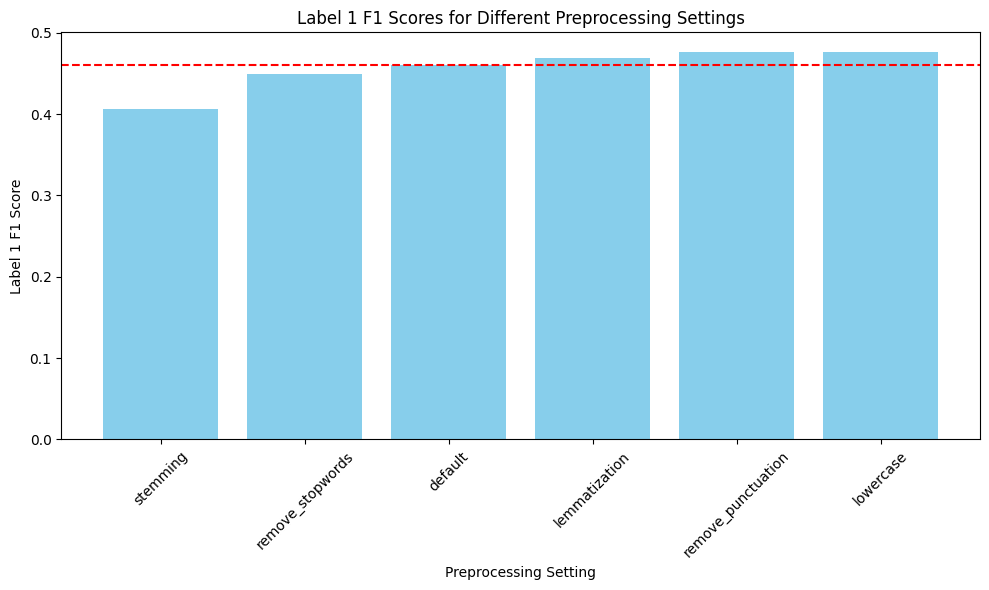

In [44]:
# Convert dictionary to DataFrame for easier manipulation
df = pd.DataFrame.from_dict(f1_results_hyperparams, orient='index', columns=['F1 Score'])

# Sort DataFrame by F1 Score in ascending order
df_sorted = df.sort_values(by='F1 Score')

# Plot the DataFrame
plt.figure(figsize=(10, 6))
for i, (index, row) in enumerate(df_sorted.iterrows()):
    if index == 'default':
        plt.bar(i, row['F1 Score'], color='skyblue', label=index)
        plt.axhline(y=row['F1 Score'], color='red', linestyle='--')
    else:
        plt.bar(i, row['F1 Score'], color='skyblue', label=index)

plt.xlabel('Preprocessing Setting')
plt.ylabel('Label 1 F1 Score')
plt.title('Label 1 F1 Scores for Different Preprocessing Settings')
plt.xticks(range(len(df_sorted)), df_sorted.index, rotation=45)
plt.tight_layout()
plt.show()

We notice that steimming at removing stopwords lowers the F1 score of the model, while lemmatization, removing punctuation, and lowercasing increases it. Thus, we will train a model which incorporates lemmatization, removing punctuation, and lowercasing as a preprocessing step.

In [45]:
train_data_downsampled['text'] = train_data_downsampled['original_text'].apply(preprocess_text, lemmatization=True, remove_punctuation=True, lowercase=True)
f1_results_hyperparams['combined'] = train_model(train_data_downsampled, val_data)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9658    0.8456    0.9017      1503
           1     0.3538    0.7384    0.4783       172

    accuracy                         0.8346      1675
   macro avg     0.6598    0.7920    0.6900      1675
weighted avg     0.9030    0.8346    0.8583      1675



In [46]:
print(f1_results_hyperparams)

{'lowercase': 0.47668393782383417, 'remove_punctuation': 0.4759493670886076, 'remove_stopwords': 0.44924406047516197, 'stemming': 0.40625, 'lemmatization': 0.46851385390428213, 'default': 0.4602510460251046, 'combined': 0.4783427495291902}


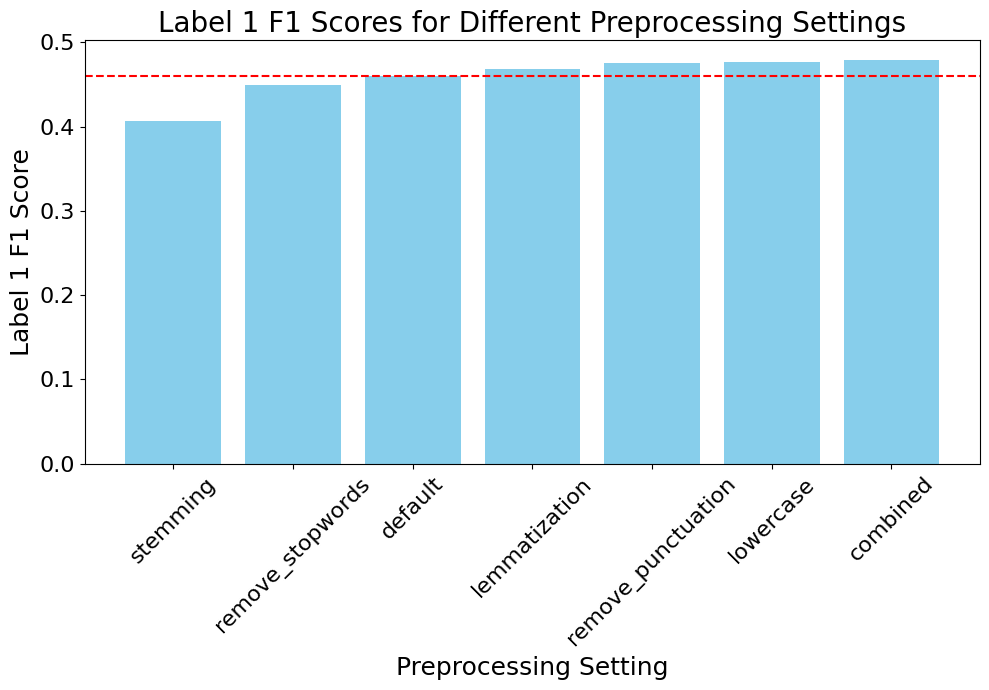

In [103]:
# Convert dictionary to DataFrame for easier manipulation
df = pd.DataFrame.from_dict(f1_results_hyperparams, orient='index', columns=['F1 Score'])

# Sort DataFrame by F1 Score in ascending order
df_sorted = df.sort_values(by='F1 Score')

# Plot the DataFrame
plt.figure(figsize=(10, 7))
for i, (index, row) in enumerate(df_sorted.iterrows()):
    if index == 'default':
        plt.bar(i, row['F1 Score'], color='skyblue', label=index)
        plt.axhline(y=row['F1 Score'], color='red', linestyle='--')
    else:
        plt.bar(i, row['F1 Score'], color='skyblue', label=index)

plt.xlabel('Preprocessing Setting', fontsize=18)
plt.ylabel('Label 1 F1 Score', fontsize=18)
plt.title('Label 1 F1 Scores for Different Preprocessing Settings', fontsize=20)
plt.xticks(range(len(df_sorted)), df_sorted.index, rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

We can see that the combined preprocessing steps achieve the best performance.

## Sampling and Data Augmentation

We now investigate if we can improve the model performance by changing the data sampling. Currently, we follow the RoBERTa baseline in performing downsampling of the majority class to twice the number of the minority class. Let's try different sampling methods to see if we can improve on this.

In [49]:
# First we perform preprocessing on all the training data using our chosen preprocessing method
train_data['text'] = train_data['original_text'].apply(preprocess_text, lemmatization=True, remove_punctuation=True, lowercase=True)
train_data.head()

,par_id,keyword,original_text,text,text_length,label_original,labels
5714,5423,disabled,Critics have even taken to dobbing in Katrina ...,critic have even taken to dobbing in katrina b...,180,0,0
7023,6890,in-need,Alexis and her family decided to donate more t...,alexis and her family decided to donate more t...,93,0,0
664,1394,vulnerable,"Mr Porter , do you think you will get the numb...",mr porter do you think you will get the number...,230,4,1
4810,4445,vulnerable,""" This only serves to highlight the importance...",this only serf to highlight the importance of ...,287,1,0
8019,7991,hopeless,""" I was nervous , but life has taught me over ...",i wa nervous but life ha taught me over the ye...,273,0,0


Let's try upsampling the minority class and downsampling the majority class. We oversample from the minority class of the same training data such that we have more points of the underrepresented minority class, and downsample the majority class to reduce the class imbalance. There are a few ways we can upsample:
1. duplicative upsampling - Having a deterministic number of copies of each data point in the minority class. If the upsampling factor is zero there is the same as not having any upsampling.
1. random upsampling - Randomly picking from the minority class of the training dataset until we have enough points.
3. data augmentation - generate synthetic examples of the minority class (rather than using copies of minority class training data). There are different data augmentation techniques we can use. We will explore two:
- Replacing words with synonyms
- Paraphrasing

In terms of downsampling, we will simply pick a subsection of the majority class according to a multiple of the size of the minority class, thus ensuring we have a fixed class imbalance ratio.

In [10]:
# Duplicative upsampling with downsampling
duplicative_upsampling_results = {}
train_label_1 = train_data[train_data.labels==1]
num_label_1 = len(train_label_1)
train_label_0 = train_data[train_data.labels==0]
num_label_0 = len(train_label_0)
print(f"Total number 1 labels: {num_label_1}")
print(f"Total number 0 labels: {num_label_0}")
print(f"Default Imbalance Ratio: {num_label_0/num_label_1}")
for downsampling_multiple in [1,2,3]:
    for upsampling_multiple in [1,2,3]:
        print(f"Training for upsampling factor {upsampling_multiple} and downsampling factor {downsampling_multiple}")
        train_label_1_samples = pd.concat([train_label_1]*upsampling_multiple).sample(frac=1, random_state=42)
        num_label_1_samples = len(train_label_1_samples)
        num_label_0_samples = num_label_1_samples*downsampling_multiple
        train_label_0_samples = train_label_0[:num_label_0_samples]
        print(f"Total samples: {num_label_1_samples + num_label_0_samples}")
        print(f"Num label 1 samples: {num_label_1_samples}")
        print(f"Num label 0 samples: {num_label_0_samples}")
        print(f"Imbalance ratio: {num_label_0_samples/num_label_1_samples}")
        train_data_updownsampled = pd.concat([train_label_1_samples,train_label_0_samples])
        duplicative_upsampling_results[f"UF={upsampling_multiple}, DF={downsampling_multiple}"] = train_model(train_data_updownsampled, val_data)

Total number 1 labels: 627
Total number 0 labels: 6073
Default Imbalance Ratio: 9.685805422647528
Training for upsampling factor 1 and downsampling factor 1
Total samples: 1254
Num label 1 samples: 627
Num label 0 samples: 627
Imbalance ratio: 1.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9820    0.6863    0.8080      1508
           1     0.2383    0.8862    0.3756       167

    accuracy                         0.7063      1675
   macro avg     0.6101    0.7863    0.5918      1675
weighted avg     0.9078    0.7063    0.7649      1675

Training for upsampling factor 2 and downsampling factor 1
Total samples: 1881
Num label 1 samples: 627
Num label 0 samples: 1254
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9542    0.8972    0.9248      1508
           1     0.3969    0.6108    0.4811       167

    accuracy                         0.8687      1675
   macro avg     0.6755    0.7540    0.7030      1675
weighted avg     0.8986    0.8687    0.8806      1675

Training for upsampling factor 3 and downsampling factor 1
Total samples: 2508
Num label 1 samples: 627
Num label 0 samples: 1881
Imbalance ratio: 3.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9474    0.9204    0.9337      1508
           1     0.4286    0.5389    0.4775       167

    accuracy                         0.8824      1675
   macro avg     0.6880    0.7297    0.7056      1675
weighted avg     0.8957    0.8824    0.8882      1675

Training for upsampling factor 1 and downsampling factor 2
Total samples: 2508
Num label 1 samples: 1254
Num label 0 samples: 1254
Imbalance ratio: 1.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9891    0.7235    0.8357      1508
           1     0.2710    0.9281    0.4195       167

    accuracy                         0.7439      1675
   macro avg     0.6300    0.8258    0.6276      1675
weighted avg     0.9175    0.7439    0.7942      1675

Training for upsampling factor 2 and downsampling factor 2
Total samples: 3762
Num label 1 samples: 1254
Num label 0 samples: 2508
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9589    0.9118    0.9347      1508
           1     0.4481    0.6467    0.5294       167

    accuracy                         0.8854      1675
   macro avg     0.7035    0.7793    0.7321      1675
weighted avg     0.9079    0.8854    0.8943      1675

Training for upsampling factor 3 and downsampling factor 2
Total samples: 5016
Num label 1 samples: 1254
Num label 0 samples: 3762
Imbalance ratio: 3.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9630    0.8985    0.9297      1508
           1     0.4291    0.6886    0.5287       167

    accuracy                         0.8776      1675
   macro avg     0.6961    0.7936    0.7292      1675
weighted avg     0.9098    0.8776    0.8897      1675

Training for upsampling factor 1 and downsampling factor 3
Total samples: 3762
Num label 1 samples: 1881
Num label 0 samples: 1881
Imbalance ratio: 1.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9753    0.8110    0.8856      1508
           1     0.3230    0.8144    0.4626       167

    accuracy                         0.8113      1675
   macro avg     0.6492    0.8127    0.6741      1675
weighted avg     0.9102    0.8113    0.8434      1675

Training for upsampling factor 2 and downsampling factor 3
Total samples: 5643
Num label 1 samples: 1881
Num label 0 samples: 3762
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/706 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9609    0.9138    0.9368      1508
           1     0.4606    0.6647    0.5441       167

    accuracy                         0.8890      1675
   macro avg     0.7108    0.7892    0.7404      1675
weighted avg     0.9111    0.8890    0.8976      1675

Training for upsampling factor 3 and downsampling factor 3
Total samples: 7524
Num label 1 samples: 1881
Num label 0 samples: 5643
Imbalance ratio: 3.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9561    0.9244    0.9400      1508
           1     0.4747    0.6168    0.5365       167

    accuracy                         0.8937      1675
   macro avg     0.7154    0.7706    0.7382      1675
weighted avg     0.9081    0.8937    0.8998      1675



In [23]:
print(duplicative_upsampling_results)

{'UF=1, DF=1': 0.3756345177664975, 'UF=1, DF=2': 0.4811320754716981, 'UF=1, DF=3': 0.47745358090185674, 'UF=2, DF=1': 0.41948579161028415, 'UF=2, DF=2': 0.5294117647058824, 'UF=2, DF=3': 0.5287356321839081, 'UF=3, DF=1': 0.46258503401360546, 'UF=3, DF=2': 0.5441176470588235, 'UF=3, DF=3': 0.5364583333333334}


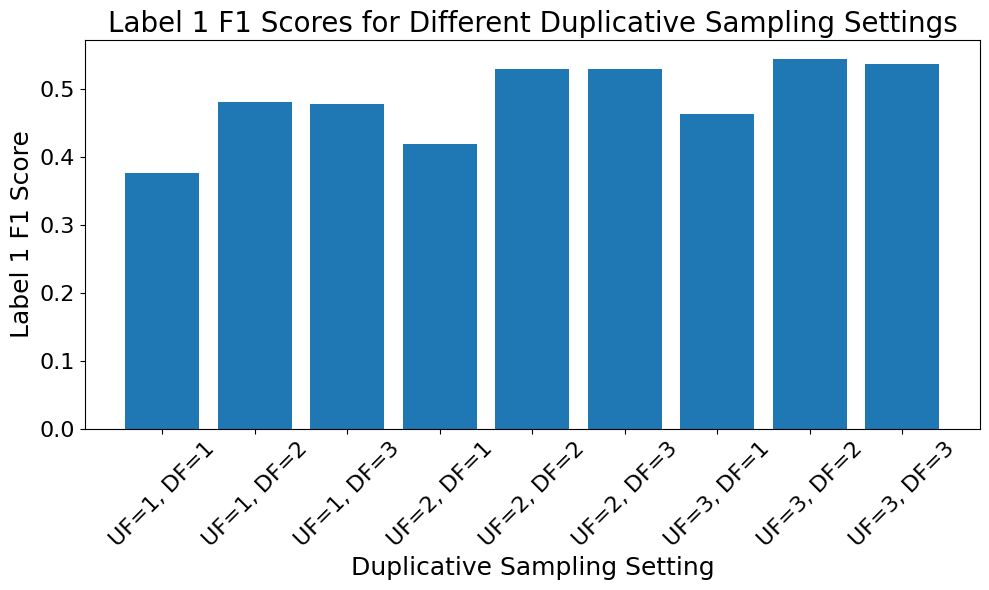

In [105]:
keys = list(duplicative_upsampling_results.keys())
values = list(duplicative_upsampling_results.values())

plt.figure(figsize=(10, 6))
plt.bar(keys, values)

plt.xlabel('Duplicative Sampling Setting', fontsize=18)
plt.ylabel('Label 1 F1 Score', fontsize=18)
plt.title('Label 1 F1 Scores for Different Duplicative Sampling Settings', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# Show the plot
plt.show()

In [18]:
# Testing if increasing the downsampling multiple even more leads to better performance
for downsampling_multiple in [9]:
    for upsampling_multiple in [1]:
        print(f"Training for upsampling factor {upsampling_multiple} and downsampling factor {downsampling_multiple}")
        train_label_1_samples = pd.concat([train_label_1]*downsampling_multiple).sample(frac=1, random_state=42)
        num_label_1_samples = len(train_label_1_samples)
        num_label_0_samples = num_label_1_samples*upsampling_multiple
        train_label_0_samples = train_label_0[:num_label_0_samples]
        print(f"Total samples: {num_label_1_samples + num_label_0_samples}")
        print(f"Num label 1 samples: {num_label_1_samples}")
        print(f"Num label 0 samples: {num_label_0_samples}")
        print(f"Imbalance ratio: {num_label_0_samples/num_label_1_samples}")
        train_data_updownsampled = pd.concat([train_label_1_samples,train_label_0_samples])
        duplicative_upsampling_results[f"UF={upsampling_multiple}, DF={downsampling_multiple}"] = train_model(train_data_updownsampled, val_data)

Training for upsampling factor 1 and downsampling factor 9
Total samples: 11286
Num label 1 samples: 5643
Num label 0 samples: 5643
Imbalance ratio: 1.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1411 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9418    0.9556    0.9487      1508
           1     0.5379    0.4671    0.5000       167

    accuracy                         0.9069      1675
   macro avg     0.7399    0.7113    0.7243      1675
weighted avg     0.9016    0.9069    0.9039      1675



In [21]:
# Adding downsampling multiple 4, upsampling multiple 2 to duplicative upsampling
for downsampling_multiple in [4]:
    for upsampling_multiple in [2]:
        print(f"Training for upsampling factor {upsampling_multiple} and downsampling factor {downsampling_multiple}")
        train_label_1_samples = pd.concat([train_label_1]*downsampling_multiple).sample(frac=1, random_state=42)
        num_label_1_samples = len(train_label_1_samples)
        num_label_0_samples = num_label_1_samples*upsampling_multiple
        train_label_0_samples = train_label_0[:num_label_0_samples]
        print(f"Total samples: {num_label_1_samples + num_label_0_samples}")
        print(f"Num label 1 samples: {num_label_1_samples}")
        print(f"Num label 0 samples: {num_label_0_samples}")
        print(f"Imbalance ratio: {num_label_0_samples/num_label_1_samples}")
        train_data_updownsampled = pd.concat([train_label_1_samples,train_label_0_samples])
        duplicative_upsampling_results[f"UF={upsampling_multiple}, DF={downsampling_multiple}"] = train_model(train_data_updownsampled, val_data)

Training for upsampling factor 2 and downsampling factor 4
Total samples: 7524
Num label 1 samples: 2508
Num label 0 samples: 5016
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9610    0.8992    0.9291      1508
           1     0.4242    0.6707    0.5197       167

    accuracy                         0.8764      1675
   macro avg     0.6926    0.7849    0.7244      1675
weighted avg     0.9075    0.8764    0.8883      1675



In [25]:
print(duplicative_upsampling_results)

{'UF=1, DF=1': 0.3756345177664975, 'UF=1, DF=2': 0.4811320754716981, 'UF=1, DF=3': 0.47745358090185674, 'UF=2, DF=1': 0.41948579161028415, 'UF=2, DF=2': 0.5294117647058824, 'UF=2, DF=3': 0.5287356321839081, 'UF=3, DF=1': 0.46258503401360546, 'UF=3, DF=2': 0.5441176470588235, 'UF=3, DF=3': 0.5364583333333334, 'UF=9, DF=1': 0.5, 'UF=4, DF=2': 0.5197215777262181}


We see that in general as the downsampling factor increases the performance increases, but also that the ideal upsampling factor is 2. Thus for the rest of the sampling experiments we will keep the upsampling factor at 2 i.e. there will be twice as many 0 class samples as 1 class samples. It's a trade-off between using less of the available training data and having the 1 class overpowered by the 0 class.

In [19]:
# Random upsampling with downsampling
from sklearn.utils import resample
# We want to use more of the training data, but this will cause the 0 class to overpower
# the 1 class. Thus, we will upsample the minority class and downsample the majority class
random_upsampling_results = {}
train_label_1 = train_data[train_data.labels==1]
num_label_1 = len(train_label_1)
train_label_0 = train_data[train_data.labels==0]
num_label_0 = len(train_label_0)
print(f"Total number 1 labels: {num_label_1}")
print(f"Total number 0 labels: {num_label_0}")
print(f"Default Imbalance Ratio: {num_label_0/num_label_1}")
for upsampling_multiple in [1,2,3,4]:
    print(f"Training for upsampling factor {upsampling_multiple} and downsampling factor 2")
    train_label_1_samples = resample(train_label_1, replace=True,
                                    n_samples=num_label_1*upsampling_multiple,
                                    random_state=42)
    num_label_1_samples = len(train_label_1_samples)
    num_label_0_samples = num_label_1_samples*2
    train_label_0_samples = train_label_0[:num_label_0_samples]
    print(f"Total samples: {num_label_1_samples + num_label_0_samples}")
    print(f"Num label 1 samples: {num_label_1_samples}")
    print(f"Num label 0 samples: {num_label_0_samples}")
    print(f"Imbalance ratio: {num_label_0_samples/num_label_1_samples}")
    train_data_updownsampled = pd.concat([train_label_1_samples,train_label_0_samples])
    random_upsampling_results[f"{upsampling_multiple}"] = train_model(train_data_updownsampled, val_data)

Total number 1 labels: 627
Total number 0 labels: 6073
Default Imbalance Ratio: 9.685805422647528
Training for upsampling factor 1 and downsampling factor 2
Total samples: 1881
Num label 1 samples: 627
Num label 0 samples: 1254
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9667    0.8674    0.9144      1508
           1     0.3789    0.7305    0.4990       167

    accuracy                         0.8537      1675
   macro avg     0.6728    0.7990    0.7067      1675
weighted avg     0.9081    0.8537    0.8730      1675

Training for upsampling factor 2 and downsampling factor 2
Total samples: 3762
Num label 1 samples: 1254
Num label 0 samples: 2508
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9598    0.9025    0.9303      1508
           1     0.4280    0.6587    0.5189       167

    accuracy                         0.8782      1675
   macro avg     0.6939    0.7806    0.7246      1675
weighted avg     0.9068    0.8782    0.8893      1675

Training for upsampling factor 3 and downsampling factor 2
Total samples: 5643
Num label 1 samples: 1881
Num label 0 samples: 3762
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/706 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9581    0.9092    0.9330      1508
           1     0.4385    0.6407    0.5207       167

    accuracy                         0.8824      1675
   macro avg     0.6983    0.7749    0.7268      1675
weighted avg     0.9063    0.8824    0.8919      1675

Training for upsampling factor 4 and downsampling factor 2
Total samples: 7524
Num label 1 samples: 2508
Num label 0 samples: 5016
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9577    0.9297    0.9435      1508
           1     0.4976    0.6287    0.5556       167

    accuracy                         0.8997      1675
   macro avg     0.7276    0.7792    0.7495      1675
weighted avg     0.9118    0.8997    0.9048      1675



In [46]:
print(random_upsampling_results)

{'1': 0.49897750511247446, '2': 0.5188679245283019, '3': 0.5206812652068127, '4': 0.5555555555555556}


While this achieves better results, random sampling is limited as it "generates" new training samples for the minority class by just sampling duplicates of the minority class. Let's see if using data augmentation to generate novel training examples for the minority class works better.

In [106]:
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import random

def synonym_replacement(text, probability=0.5):
    tokens = word_tokenize(text)
    for i, token in enumerate(tokens):
        if wordnet.synsets(token) and random.random() <= probability:
            synonyms = [synset.lemmas()[0].name() for synset in wordnet.synsets(token)]
            if synonyms:
                replacement = random.choice(synonyms)
                tokens[i] = replacement
    return ' '.join(tokens)

In [107]:
example_text = train_label_1[train_label_1["par_id"] == 1394]["original_text"].iloc[0]
print(example_text)
print(synonym_replacement(example_text))
print(synonym_replacement(example_text))

Mr Porter , do you think you will get the numbers needed from the remaining senators and do you agree that , if implemented , some vulnerable people will fall through the cracks and the streets could be un-safer as a consequence ?
Mister Porter , cause you think you will catch the number necessitate from the remaining senators and do you agree that , if follow_through , some vulnerable citizenry volition fall through the cracks and the street could embody un-safer as adenine consequence ?
Mister Porter , act you think you bequeath induce the numbers need from the stay senator and do you agree that , if implemented , some vulnerable people will spill through the cracks and the streets could be un-safer deoxyadenosine_monophosphate a consequence ?


In [39]:
# Data augmentation (synonym replacement) with downsampling
from sklearn.utils import resample
synonym_augmentation_results = {}
train_label_1 = train_data[train_data.labels==1]
num_label_1 = len(train_label_1)
train_label_0 = train_data[train_data.labels==0]
num_label_0 = len(train_label_0)
print(f"Total number 1 labels: {num_label_1}")
print(f"Total number 0 labels: {num_label_0}")
print(f"Default Imbalance Ratio: {num_label_0/num_label_1}")
for upsampling_multiple in [2,3,4]:
    print(f"Training for upsampling factor {upsampling_multiple} and downsampling factor 2")
    train_label_1_default = train_label_1.copy()
    train_label_1_augmented = pd.concat([train_label_1]*(upsampling_multiple - 1))
    train_label_1_augmented["text"] = train_label_1_augmented["original_text"].apply(synonym_replacement).apply(preprocess_text, lemmatization=True, remove_punctuation=True, lowercase=True)
    train_label_1_samples = pd.concat([train_label_1_default, train_label_1_augmented])
    num_label_1_samples = len(train_label_1_samples)
    num_label_0_samples = num_label_1_samples*2
    train_label_0_samples = train_label_0[:num_label_0_samples]
    print(f"Total samples: {num_label_1_samples + num_label_0_samples}")
    print(f"Num label 1 samples: {num_label_1_samples}")
    print(f"Num label 0 samples: {num_label_0_samples}")
    print(f"Imbalance ratio: {num_label_0_samples/num_label_1_samples}")
    train_data_updownsampled = pd.concat([train_label_1_samples,train_label_0_samples])
    synonym_augmentation_results[f"{upsampling_multiple}"] = train_model(train_data_updownsampled, val_data)

Total number 1 labels: 627
Total number 0 labels: 6073
Default Imbalance Ratio: 9.685805422647528
Training for upsampling factor 2 and downsampling factor 2
Total samples: 3762
Num label 1 samples: 1254
Num label 0 samples: 2508
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9558    0.9171    0.9360      1508
           1     0.4518    0.6168    0.5215       167

    accuracy                         0.8872      1675
   macro avg     0.7038    0.7669    0.7288      1675
weighted avg     0.9055    0.8872    0.8947      1675

Training for upsampling factor 3 and downsampling factor 2
Total samples: 5643
Num label 1 samples: 1881
Num label 0 samples: 3762
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/706 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9308    0.9629    0.9465      1508
           1     0.5130    0.3533    0.4184       167

    accuracy                         0.9021      1675
   macro avg     0.7219    0.6581    0.6825      1675
weighted avg     0.8891    0.9021    0.8939      1675

Training for upsampling factor 4 and downsampling factor 2
Total samples: 7524
Num label 1 samples: 2508
Num label 0 samples: 5016
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9192    0.9881    0.9524      1508
           1     0.6667    0.2156    0.3258       167

    accuracy                         0.9110      1675
   macro avg     0.7929    0.6018    0.6391      1675
weighted avg     0.8940    0.9110    0.8899      1675



In [40]:
print(synonym_augmentation_results)

{'2': 0.5215189873417722, '3': 0.41843971631205673, '4': 0.3257918552036199}


#### Paraphrasing

In [10]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"

# load pre-trained Pegasus Paraphrase model and tokenizer
pegasus_model_name = "tuner007/pegasus_paraphrase"
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name).to(device)

/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
def paraphrase_text(input_text, temperature=1.5, max_length=60, num_sequences=3):
    # Tokenize the input sentence
    input_ids = pegasus_tokenizer.encode(input_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)
    # Generate paraphrased sentence
    paraphrase_ids = pegasus_model.generate(input_ids, num_beams=num_sequences, max_length=max_length, do_sample=True, early_stopping=True, temperature=temperature).to(device)
    # Decode
    paraphrase = pegasus_tokenizer.decode(paraphrase_ids[0], skip_special_tokens=True)
    return paraphrase

In [69]:
train_label_1 = train_data[train_data.labels==1]
train_label_0 = train_data[train_data.labels==0]
example_text = train_label_1[train_label_1["par_id"] == 1394]["original_text"].iloc[0]
print(example_text)
print(paraphrase_text(example_text))
print(paraphrase_text(example_text))
print(paraphrase_text(example_text))

Mr Porter , do you think you will get the numbers needed from the remaining senators and do you agree that , if implemented , some vulnerable people will fall through the cracks and the streets could be un-safer as a consequence ?
Do you believe that you will get the numbers from the remaining senates so that we can keep the streets safe, and do you agree with the idea that vulnerable people will fall through the cracks?
Is it possible that some vulnerable people will fall through the cracks if implemented, and the streets will be unsafe as a consequence, as you think you can get the numbers from the remaining senators?
Mr Porter, do you believe that if implemented, some vulnerable people will fall through the cracks and the streets will be unsafe, do you agree with that?


In [70]:
paraphrase_augmented_block_1 = train_label_1.copy()
paraphrase_augmented_block_1["text"] = paraphrase_augmented_block_1["original_text"].apply(paraphrase_text).apply(preprocess_text, lemmatization=True, remove_punctuation=True, lowercase=True)

In [71]:
paraphrase_augmented_block_2 = train_label_1.copy()
paraphrase_augmented_block_2["text"] = paraphrase_augmented_block_2["original_text"].apply(paraphrase_text).apply(preprocess_text, lemmatization=True, remove_punctuation=True, lowercase=True)

In [72]:
paraphrase_augmented_block_3 = train_label_1.copy()
paraphrase_augmented_block_3["text"] = paraphrase_augmented_block_3["original_text"].apply(paraphrase_text).apply(preprocess_text, lemmatization=True, remove_punctuation=True, lowercase=True)

In [73]:
paraphrase_augmented_train_label_1 = pd.concat([paraphrase_augmented_block_1, paraphrase_augmented_block_2, paraphrase_augmented_block_3])

In [75]:
import pickle
paraphrase_augmented_train_label_1.to_pickle("augmented_data")

In [89]:
print(paraphrase_augmented_train_label_1[paraphrase_augmented_train_label_1["par_id"] == 1394]["text"])

664    mr porter are you sure you will get the number...
664    mr porter do you believe that the government w...
664    mr porter do you think that the street are saf...
Name: text, dtype: object


In [10]:
import pickle
with open('augmented_data', 'rb') as f:
    paraphrase_augmented_train_label_1 = pickle.load(f)

In [14]:
# Data augmentation (paraphrasing) with downsampling
from sklearn.utils import resample
paraphrasing_augmentation_results = {}
train_label_1 = train_data[train_data.labels==1]
num_label_1 = len(train_label_1)
train_label_0 = train_data[train_data.labels==0]
num_label_0 = len(train_label_0)
print(f"Total number 1 labels: {num_label_1}")
print(f"Total number 0 labels: {num_label_0}")
print(f"Default Imbalance Ratio: {num_label_0/num_label_1}")
for upsampling_multiple in [2,3,4]:
    print(f"Training for upsampling factor {upsampling_multiple} and downsampling factor 2")
    train_label_1_default = train_label_1.copy()
    train_label_1_augmented = paraphrase_augmented_train_label_1[:num_label_1*(upsampling_multiple - 1)]
    train_label_1_samples = pd.concat([train_label_1_default, train_label_1_augmented])
    num_label_1_samples = len(train_label_1_samples)
    num_label_0_samples = num_label_1_samples*2
    train_label_0_samples = train_label_0[:num_label_0_samples]
    print(f"Total samples: {num_label_1_samples + num_label_0_samples}")
    print(f"Num label 1 samples: {num_label_1_samples}")
    print(f"Num label 0 samples: {num_label_0_samples}")
    print(f"Imbalance ratio: {num_label_0_samples/num_label_1_samples}")
    train_data_updownsampled = pd.concat([train_label_1_samples,train_label_0_samples])
    paraphrasing_augmentation_results[f"{upsampling_multiple}"] = train_model(train_data_updownsampled, val_data)

Total number 1 labels: 627
Total number 0 labels: 6073
Default Imbalance Ratio: 9.685805422647528
Training for upsampling factor 2 and downsampling factor 2
Total samples: 3762
Num label 1 samples: 1254
Num label 0 samples: 2508
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9618    0.8680    0.9125      1508
           1     0.3662    0.6886    0.4782       167

    accuracy                         0.8501      1675
   macro avg     0.6640    0.7783    0.6953      1675
weighted avg     0.9024    0.8501    0.8692      1675

Training for upsampling factor 3 and downsampling factor 2
Total samples: 5643
Num label 1 samples: 1881
Num label 0 samples: 3762
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/706 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9526    0.8793    0.9145      1508
           1     0.3569    0.6048    0.4489       167

    accuracy                         0.8519      1675
   macro avg     0.6547    0.7421    0.6817      1675
weighted avg     0.8932    0.8519    0.8681      1675

Training for upsampling factor 4 and downsampling factor 2
Total samples: 7524
Num label 1 samples: 2508
Num label 0 samples: 5016
Imbalance ratio: 2.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9517    0.8886    0.9191      1508
           1     0.3708    0.5928    0.4562       167

    accuracy                         0.8591      1675
   macro avg     0.6612    0.7407    0.6876      1675
weighted avg     0.8938    0.8591    0.8729      1675



In [15]:
print(paraphrasing_augmentation_results)

{'2': 0.4781704781704782, '3': 0.4488888888888889, '4': 0.45622119815668205}


In [60]:
combined_sampling_results = {}
for i in [2,3,4]:
    combined_sampling_results[f"duplicative UF {i}"] = duplicative_upsampling_results[f'UF={i}, DF=2']
for k, v in random_upsampling_results.items():
    if k != '1':
        combined_sampling_results[f"random UF {k}"] = v
for k, v in synonym_augmentation_results.items():
    combined_sampling_results[f"synonym UF {k}"] = v
for k, v in paraphrasing_augmentation_results.items():
    combined_sampling_results[f"paraphrase UF {k}"] = v
print(combined_sampling_results)

{'duplicative UF 2': 0.5294117647058824, 'duplicative UF 3': 0.5441176470588235, 'duplicative UF 4': 0.5197215777262181, 'random UF 2': 0.5188679245283019, 'random UF 3': 0.5206812652068127, 'random UF 4': 0.5555555555555556, 'synonym UF 2': 0.5215189873417722, 'synonym UF 3': 0.41843971631205673, 'synonym UF 4': 0.3257918552036199, 'paraphrase UF 2': 0.4781704781704782, 'paraphrase UF 3': 0.4488888888888889, 'paraphrase UF 4': 0.45622119815668205}


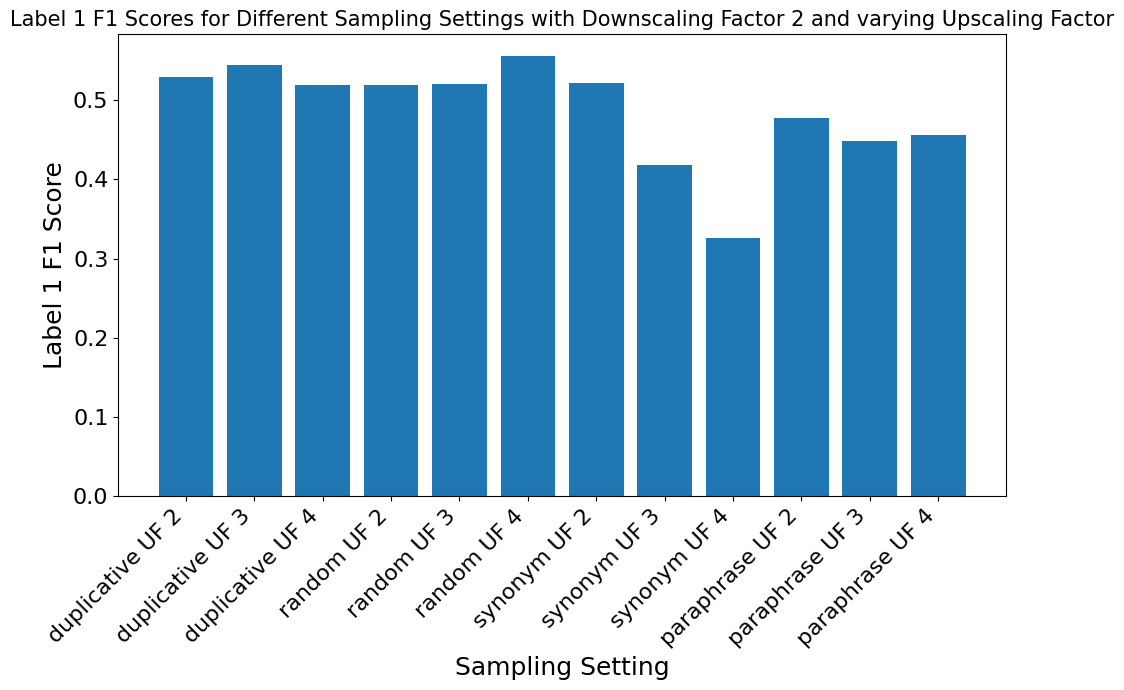

In [109]:
keys = list(combined_sampling_results.keys())
values = list(combined_sampling_results.values())

plt.figure(figsize=(10, 7))
plt.bar(keys, values)

plt.xlabel('Sampling Setting', fontsize=18)
plt.ylabel('Label 1 F1 Score', fontsize=18)
plt.title('Label 1 F1 Scores for Different Sampling Settings with Downscaling Factor 2 and varying Upscaling Factor', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# Show the plot
plt.show()

We conclude that the best sampling strategy is actually just random sampling with an upsampling factor of 4 and a downsampling factor of 2. We will create the final training data as appropriate.

In [14]:
# Thus, the best performing sampling strategy is just random upsampling with a factor of 4
# and random downsampling with a factor of 2
from sklearn.utils import resample
train_label_1 = train_data[train_data.labels==1]
num_label_1 = len(train_label_1)
train_label_0 = train_data[train_data.labels==0]
num_label_0 = len(train_label_0)
train_label_1_samples = resample(train_label_1, replace=True,
                                    n_samples=num_label_1*4,
                                    random_state=42)
num_label_1_samples = len(train_label_1_samples)
num_label_0_samples = num_label_1_samples*2
train_label_0_samples = train_label_0[:num_label_0_samples]
print(f"Total samples: {num_label_1_samples + num_label_0_samples}")
print(f"Num label 1 samples: {num_label_1_samples}")
print(f"Num label 0 samples: {num_label_0_samples}")
print(f"Imbalance ratio: {num_label_0_samples/num_label_1_samples}")
train_data_updownsampled = pd.concat([train_label_1_samples,train_label_0_samples])

Total samples: 7524
Num label 1 samples: 2508
Num label 0 samples: 5016
Imbalance ratio: 2.0


## Hyperparameter Tuning

Now that we've found good preprocessing steps, sampling steps and data augmentation steps, let's finetune the hyperparameters of our model to get the best possible performance. We will finetune the "learning_rate" and "scheduler" hyperparameters.

In [62]:
hyperparam_tuning_results = {}
for learning_rate in [1e-5, 4e-5, 1e-4]:
    for scheduler in ["constant_schedule", "constant_schedule_with_warmup", "linear_schedule_with_warmup", "cosine_schedule_with_warmup"]:
        print(f"Training with learning rate {learning_rate} and scheduler {scheduler}")
        hyperparam_tuning_results[f"lr={learning_rate} scheduler={scheduler}"] = train_model(train_data_updownsampled, val_data, learning_rate=learning_rate, scheduler=scheduler)

Training with learning rate 1e-05 and scheduler constant_schedule


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9438    0.9576    0.9506      1508
           1     0.5586    0.4850    0.5192       167

    accuracy                         0.9104      1675
   macro avg     0.7512    0.7213    0.7349      1675
weighted avg     0.9054    0.9104    0.9076      1675

Training with learning rate 1e-05 and scheduler constant_schedule_with_warmup


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9511    0.9290    0.9400      1508
           1     0.4703    0.5689    0.5149       167

    accuracy                         0.8931      1675
   macro avg     0.7107    0.7490    0.7274      1675
weighted avg     0.9032    0.8931    0.8976      1675

Training with learning rate 1e-05 and scheduler linear_schedule_with_warmup


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9626    0.9045    0.9326      1508
           1     0.4419    0.6826    0.5365       167

    accuracy                         0.8824      1675
   macro avg     0.7022    0.7936    0.7346      1675
weighted avg     0.9107    0.8824    0.8931      1675

Training with learning rate 1e-05 and scheduler cosine_schedule_with_warmup


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9634    0.9065    0.9341      1508
           1     0.4492    0.6886    0.5437       167

    accuracy                         0.8848      1675
   macro avg     0.7063    0.7976    0.7389      1675
weighted avg     0.9121    0.8848    0.8951      1675

Training with learning rate 4e-05 and scheduler constant_schedule


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9587    0.8939    0.9252      1508
           1     0.4052    0.6527    0.5000       167

    accuracy                         0.8699      1675
   macro avg     0.6820    0.7733    0.7126      1675
weighted avg     0.9036    0.8699    0.8828      1675

Training with learning rate 4e-05 and scheduler constant_schedule_with_warmup


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9003    1.0000    0.9475      1508
           1     0.0000    0.0000    0.0000       167

    accuracy                         0.9003      1675
   macro avg     0.4501    0.5000    0.4738      1675
weighted avg     0.8105    0.9003    0.8531      1675

Training with learning rate 4e-05 and scheduler linear_schedule_with_warmup


/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9635    0.9111    0.9366      1508
           1     0.4618    0.6886    0.5529       167

    accuracy                         0.8890      1675
   macro avg     0.7127    0.7999    0.7447      1675
weighted avg     0.9135    0.8890    0.8983      1675

Training with learning rate 4e-05 and scheduler cosine_schedule_with_warmup


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9607    0.9085    0.9339      1508
           1     0.4458    0.6647    0.5337       167

    accuracy                         0.8842      1675
   macro avg     0.7033    0.7866    0.7338      1675
weighted avg     0.9094    0.8842    0.8940      1675

Training with learning rate 0.0001 and scheduler constant_schedule


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9003    1.0000    0.9475      1508
           1     0.0000    0.0000    0.0000       167

    accuracy                         0.9003      1675
   macro avg     0.4501    0.5000    0.4738      1675
weighted avg     0.8105    0.9003    0.8531      1675

Training with learning rate 0.0001 and scheduler constant_schedule_with_warmup


/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9003    1.0000    0.9475      1508
           1     0.0000    0.0000    0.0000       167

    accuracy                         0.9003      1675
   macro avg     0.4501    0.5000    0.4738      1675
weighted avg     0.8105    0.9003    0.8531      1675

Training with learning rate 0.0001 and scheduler linear_schedule_with_warmup


/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9003    1.0000    0.9475      1508
           1     0.0000    0.0000    0.0000       167

    accuracy                         0.9003      1675
   macro avg     0.4501    0.5000    0.4738      1675
weighted avg     0.8105    0.9003    0.8531      1675

Training with learning rate 0.0001 and scheduler cosine_schedule_with_warmup


/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9003    1.0000    0.9475      1508
           1     0.0000    0.0000    0.0000       167

    accuracy                         0.9003      1675
   macro avg     0.4501    0.5000    0.4738      1675
weighted avg     0.8105    0.9003    0.8531      1675



/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [63]:
print(hyperparam_tuning_results)

{'lr=1e-05 scheduler=constant_schedule': 0.5192307692307693, 'lr=1e-05 scheduler=constant_schedule_with_warmup': 0.5149051490514905, 'lr=1e-05 scheduler=linear_schedule_with_warmup': 0.5364705882352941, 'lr=1e-05 scheduler=cosine_schedule_with_warmup': 0.5437352245862884, 'lr=4e-05 scheduler=constant_schedule': 0.5, 'lr=4e-05 scheduler=constant_schedule_with_warmup': 0.0, 'lr=4e-05 scheduler=linear_schedule_with_warmup': 0.5528846153846154, 'lr=4e-05 scheduler=cosine_schedule_with_warmup': 0.5336538461538461, 'lr=0.0001 scheduler=constant_schedule': 0.0, 'lr=0.0001 scheduler=constant_schedule_with_warmup': 0.0, 'lr=0.0001 scheduler=linear_schedule_with_warmup': 0.0, 'lr=0.0001 scheduler=cosine_schedule_with_warmup': 0.0}


In [116]:
renamed_hyperparam_tuning_results = {'lr=1e-5 sched=CS': 0.5192307692307693, 'lr=1e-5 sched=CSWW': 0.5149051490514905, 'lr=1e-5 sched=LSWW': 0.5364705882352941, 'lr=1e-5 sched=CosSWW': 0.5437352245862884, 'lr=4e-5 sched=CS': 0.5, 'lr=4e-5 sched=CSWW': 0.0, 'lr=4e-5 sched=LSWW': 0.5528846153846154, 'lr=4e-5 sched=CosSWW': 0.5336538461538461, 'lr=1e-4 sched=CS': 0.0, 'lr=1e-4 sched=CSWW': 0.0, 'lr=1e-4 scheduler=LSWW': 0.0, 'lr=1e-4 sched=CosSWW': 0.0}

In [119]:
renamed_hyperparam_tuning_results = {'lr=1e-5 sched=CS': 0.5192307692307693, 'lr=1e-5 sched=CSWW': 0.5149051490514905, 'lr=1e-5 sched=LSWW': 0.5364705882352941, 'lr=1e-5 sched=CosSWW': 0.5437352245862884, 'lr=4e-5 sched=CS': 0.5, 'lr=4e-5 sched=CSWW': 0.0, 'lr=4e-5 sched=LSWW': 0.5528846153846154, 'lr=4e-5 sched=CosSWW': 0.5336538461538461}

In [120]:
print(renamed_hyperparam_tuning_results)

{'lr=1e-5 sched=CS': 0.5192307692307693, 'lr=1e-5 sched=CSWW': 0.5149051490514905, 'lr=1e-5 sched=LSWW': 0.5364705882352941, 'lr=1e-5 sched=CosSWW': 0.5437352245862884, 'lr=4e-5 sched=CS': 0.5, 'lr=4e-5 sched=CSWW': 0.0, 'lr=4e-5 sched=LSWW': 0.5528846153846154, 'lr=4e-5 sched=CosSWW': 0.5336538461538461}


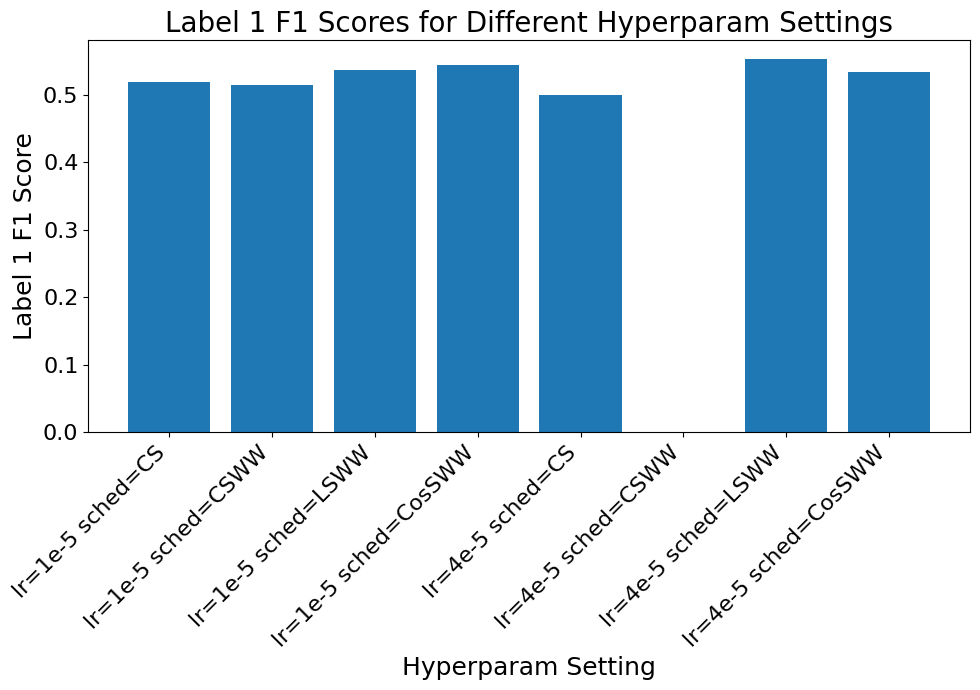

In [121]:
keys = list(renamed_hyperparam_tuning_results.keys())
values = list(renamed_hyperparam_tuning_results.values())

plt.figure(figsize=(10, 7))
plt.bar(keys, values)

plt.xlabel('Hyperparam Setting', fontsize=18)
plt.ylabel('Label 1 F1 Score', fontsize=18)
plt.title('Label 1 F1 Scores for Different Hyperparam Settings', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# Show the plot
plt.show()

## BoW Model for Comparison

We will train a simple bag of words model for comparison purposes.

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

train_text = train_data_updownsampled['text'].tolist()
train_labels = train_data_updownsampled['labels'].astype(int)
val_text = val_data['text'].tolist()
val_labels = val_data['labels'].astype(int) 

# Generate BoW representation
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_text)
X_val = vectorizer.transform(val_text)

# Train logistic regression model
clf = LogisticRegression()
clf.fit(X_train, train_labels)

# Generate predictions
val_predictions = clf.predict(X_val)
print(classification_report(val_labels, val_predictions, digits=4))
precision, recall, f1_score, support = precision_recall_fscore_support(val_labels, val_predictions)
print(f1_score[1])

              precision    recall  f1-score   support

           0     0.9240    0.9589    0.9411      1508
           1     0.4364    0.2874    0.3466       167

    accuracy                         0.8919      1675
   macro avg     0.6802    0.6232    0.6438      1675
weighted avg     0.8753    0.8919    0.8818      1675

0.34657039711191334


## Final Model

In [21]:
# Train Final Model with ideal sampling and hyperparameters
learning_rate = 4e-05
scheduler = "linear_schedule_with_warmup"
model_type = "roberta"
model_name = "roberta-base"
optimizer = "AdamW"
num_epoch = 1

model_args = ClassificationArgs(num_train_epochs=num_epoch, 
                                no_save=True, 
                                no_cache=True, 
                                overwrite_output_dir=True,
                                use_multiprocessing=False,
                                use_multiprocessing_for_evaluation=False,
                                train_batch_size=8,
                                eval_batch_size=8,
                                learning_rate=learning_rate,
                                scheduler=scheduler,
                                optimizer=optimizer)
model = ClassificationModel(model_type,
                            model_name, 
                            args = model_args, 
                            num_labels=2, 
                            use_cuda=cuda_available)
# train model
final_model = model.train_model(train_data_updownsampled[['text', 'labels']])

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/941 [00:00<?, ?it/s]

Results on validation data

In [22]:
y_pred, _ = model.predict(val_data.text.tolist())
y_true = val_data['labels']
print("Validation Set Metrics")
print(classification_report(y_true, y_pred, digits=4))
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)
print(f1_score[1])

  0%|          | 0/210 [00:00<?, ?it/s]

Validation Set Metrics
              precision    recall  f1-score   support

           0     0.9437    0.9443    0.9440      1508
           1     0.4940    0.4910    0.4925       167

    accuracy                         0.8991      1675
   macro avg     0.7188    0.7177    0.7182      1675
weighted avg     0.8988    0.8991    0.8990      1675

0.4924924924924925


Results on test data (official validation data)

In [23]:
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [47]:
val_y_pred, _ = model.predict(test_data.text.tolist())
val_y_true = test_data['labels']
print("Test Set (Official Validation Set) Metrics")
print(classification_report(val_y_true, val_y_pred, digits=4))
precision, recall, f1_score, support = precision_recall_fscore_support(val_y_true, val_y_pred)
print(f1_score[1])
labels2file([[k] for k in val_y_pred], 'dev.txt')

  0%|          | 0/262 [00:00<?, ?it/s]

Test Set (Official Validation Set) Metrics
              precision    recall  f1-score   support

           0     0.9544    0.9499    0.9521      1895
           1     0.5433    0.5678    0.5553       199

    accuracy                         0.9136      2094
   macro avg     0.7488    0.7589    0.7537      2094
weighted avg     0.9153    0.9136    0.9144      2094

0.5552825552825553


Results on official test data

In [25]:
official_test_data = load_test_data(test_path)
test_y_pred, _ = model.predict(official_test_data.text.tolist())
labels2file([[k] for k in y_pred], 'test.txt')

  0%|          | 0/479 [00:00<?, ?it/s]

## Analysis

In [50]:
# Add the predictions to the test dataframe
test_data = test_data.assign(predictions=val_y_pred)
test_data.head()

,par_id,keyword,original_text,text,text_length,label_original,labels,predictions
0,4046,hopeless,We also know that they can benefit by receivin...,We also know that they can benefit by receivin...,493,3,1,0
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,Pope Francis washed and kissed the feet of Mus...,197,4,1,0
2,8330,refugee,Many refugees do n't want to be resettled anyw...,Many refugees do n't want to be resettled anyw...,74,2,1,0
3,4063,in-need,"Budding chefs , like "" Fred "" , "" Winston "" an...","Budding chefs , like "" Fred "" , "" Winston "" an...",210,4,1,1
4,4089,homeless,"In a 90-degree view of his constituency , one ...","In a 90-degree view of his constituency , one ...",351,3,1,0


To what extent is the model better at predicting examples with a higher level of patronising content? Justify your answer.

In [63]:
correct_predictions_percentage = test_data.groupby('label_original')[['labels', 'predictions']].apply(lambda group: (group['labels'] == group['predictions']).mean() * 100)
print(correct_predictions_percentage)

label_original
0    96.596244
1    80.628272
2    11.111111
3    51.685393
4    70.652174
dtype: float64


In [68]:
percent_label_1 = test_data.groupby('label_original')[['labels']].apply(lambda group: (group['labels']).mean() * 100)
print(percent_label_1)

label_original
0      0.0
1      0.0
2    100.0
3    100.0
4    100.0
dtype: float64


In [64]:
from sklearn.metrics import f1_score
correct_predictions_percentage = test_data.groupby('label_original').apply(lambda group: f1_score(group['labels'], group['predictions'], pos_label=1))
print(correct_predictions_percentage)

label_original
0    0.000000
1    0.000000
2    0.200000
3    0.681481
4    0.828025
dtype: float64


/tmp/ipykernel_132/2705412179.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correct_predictions_percentage = test_data.groupby('label_original').apply(lambda group: f1_score(group['labels'], group['predictions'], pos_label=1))


How does the length of the input sequence impact the model performance? If there is any difference, speculate why.

In [75]:
bucket_size = 200
test_data['text_length_bucket'] = (test_data['text_length'] // bucket_size) * bucket_size
test_data['text_length_bucket'] = test_data['text_length_bucket'].where(test_data['text_length_bucket'] < 1000, other="1000+")
correct_predictions_percentage = test_data.groupby('text_length_bucket')[['labels', 'predictions']].apply(lambda group: (group['labels'] == group['predictions']).mean() * 100)
print(correct_predictions_percentage)

text_length_bucket
0         92.412935
200       91.540785
400       89.140271
600       83.333333
800       83.333333
1000+    100.000000
dtype: float64


In [76]:
correct_predictions_percentage = test_data.groupby('text_length_bucket')[['labels', 'predictions']].apply(lambda group: f1_score(group['labels'], group['predictions'], pos_label=1))
print(correct_predictions_percentage)

text_length_bucket
0        0.567376
200      0.557895
400      0.571429
600      0.375000
800      0.500000
1000+    0.000000
dtype: float64


/home/jonezia/NLP_CW/DontPatroniseMe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
percent_label_1 = test_data.groupby('text_length_bucket')[['labels']].apply(lambda group: (group['labels']).mean() * 100)
print(percent_label_1)

text_length_bucket
0         7.960199
200       9.566969
400      13.574661
600      13.333333
800      16.666667
1000+     0.000000
dtype: float64


To what extent does model performance depend on the data categories? E.g. Observations for homeless vs poor-families, etc.

In [57]:
correct_predictions_percentage = test_data.groupby('keyword')[['labels', 'predictions']].apply(lambda group: (group['labels'] == group['predictions']).mean() * 100)
print(correct_predictions_percentage)

keyword
disabled         92.783505
homeless         83.962264
hopeless         85.714286
immigrant        97.247706
in-need          90.265487
migrant          98.550725
poor-families    83.684211
refugee          94.148936
vulnerable       92.344498
women            94.420601
dtype: float64


In [69]:
percent_label_1 = test_data.groupby('keyword')[['labels']].apply(lambda group: (group['labels']).mean() * 100)
print(percent_label_1)

keyword
disabled          7.216495
homeless         13.679245
hopeless         11.981567
immigrant         3.211009
in-need          14.601770
migrant           2.415459
poor-families    20.000000
refugee           6.914894
vulnerable        9.569378
women             6.008584
dtype: float64


In [65]:
correct_predictions_percentage = test_data.groupby('keyword')[['labels', 'predictions']].apply(lambda group: f1_score(group['labels'], group['predictions'], pos_label=1))
print(correct_predictions_percentage)

keyword
disabled         0.500000
homeless         0.484848
hopeless         0.436364
immigrant        0.250000
in-need          0.731707
migrant          0.666667
poor-families    0.563380
refugee          0.476190
vulnerable       0.619048
women            0.480000
dtype: float64
